In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# Define important features for each position (from feature importance analysis)
common_features = ["age", "league_strength"]  # Features common to all players
position_features = {
    "FW": ["% Medium passes completed", "Pass completion %",""],
    "MF": ["assists p 90", "key passes", "progressive passes", "shot creating actions p 90", "goal creating actions p 90"],
    "DF": ["tackles won", "interceptions", "clearances", "% aerial duels won", "pass completion %"],
    "GK": ["saves %", "goals against p 90", "clean sheets", "% penalty saves", "crosses stopped"]
}

# Define target variable (numeric performance metric)
target_column = "performance_metric"  # You will need to define this!

# Create position-wise LSTM models
position_models = {}

for position, features in position_features.items():
    print(f"\n📊 Training LSTM model for {position}...")

    # Select relevant features
    selected_features = common_features + features

    # Filter data for the position
    pos_df = df[df["pos"] == position].copy()

    # Ensure we have enough data
    if len(pos_df) < 50:
        print(f"⚠️ Not enough data for {position}. Skipping...\n")
        continue

    # 🧹 Normalize the selected features
    scaler = MinMaxScaler()
    pos_df[selected_features] = scaler.fit_transform(pos_df[selected_features])

    # Create sequences for LSTM (Past 7 seasons → Predict next season)
    sequence_length = 7  # Use past 7 seasons to predict the next
    X, y = [], []

    for i in range(len(pos_df) - sequence_length):
        X.append(pos_df[selected_features].iloc[i : i + sequence_length].values)
        y.append(pos_df[target_column].iloc[i + sequence_length])

    X, y = np.array(X), np.array(y)

    # Train-Test Split (80% train, 20% validation)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

    # Define LSTM model
    model = Sequential([
        LSTM(64, activation="tanh", return_sequences=True, input_shape=(sequence_length, len(selected_features))),
        Dropout(0.2),
        LSTM(32, activation="tanh"),
        Dropout(0.2),
        Dense(16, activation="relu"),
        Dense(1)  # Output: Predicted Performance Metric
    ])

    model.compile(optimizer=Adam(learning_rate=0.001), loss="mse", metrics=["mae"])

    # Train the model
    history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=8, verbose=1)

    # Store trained model
    position_models[position] = (model, scaler, selected_features)

    print(f"Training complete for {position}!\n")


📊 Training LSTM model for FW...


NameError: name 'df' is not defined

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Load dataset
df = pd.read_csv("cleaned_all_seasons.csv")  # Update with the correct file path

# Extract all numerical columns (excluding categorical columns like player names)
numerical_columns = df.select_dtypes(include=[np.number]).columns.tolist()

# Define position-specific players
positions = df["pos"].unique()  # Get all unique positions (FW, MF, DF, GK)

# Dictionary to store feature importance results
feature_importance_results = {}

# Loop through each position
for position in positions:
    print(f"\n🔍 Analyzing position: {position}...\n")

    # Filter dataset for the specific position
    pos_df = df[df["pos"] == position]

    # Ensure we have enough data
    if len(pos_df) < 50:
        print(f"Not enough data for {position}. Skipping...\n")
        continue

    # Extract only numerical features
    X = pos_df[numerical_columns]

    # Standardize features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Apply PCA
    pca = PCA(n_components=1)  # First principal component (captures main variance)
    pca.fit(X_scaled)

    # Get feature weightage
    feature_importance = pd.DataFrame({"Feature": numerical_columns, "Weight": np.abs(pca.components_[0])})
    feature_importance = feature_importance.sort_values(by="Weight", ascending=False).head(15)  # Select top 15 features

    # Normalize weights (so they sum up to 1)
    feature_importance["Weight"] = feature_importance["Weight"] / feature_importance["Weight"].sum()

    # Store results
    feature_importance_results[position] = feature_importance

    # Plot feature importance
    plt.figure(figsize=(12, 6))
    sns.barplot(x="Weight", y="Feature", data=feature_importance, palette="coolwarm")
    plt.title(f"Top 15 Important Features for {position} (PCA Analysis)")
    plt.xlabel("Importance Score")
    plt.ylabel("Feature")
    plt.show()


In [ ]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Load dataset
df = pd.read_csv("/content/cleaned_all_seasons.csv")

# Define position-specific features
position_metrics = {
    "FW": ["Avg Mins per Match","Goals","Assists","Non Penalty Goals","Penalty Kicks Made","Exp NPG","Progressive Carries","Progressive Passes","Goals p 90","Assists p 90","Pass completion %","Key passes","Passes into penalty area","Take ons attempted","% Successful take-ons","Times tackled during take-on","% Shots on target","Shots p 90","Goals per shot","Goals per shot on target","Goal creating actions p 90","Expected Goals", "Shots p 90", "Goal creating actions p 90", "Progressive Carries"],
    "MF": ["Avg Mins per Match","Goals","Assists", "Non Penalty Goals","Penalty Kicks Made","Expected Goals","Exp NPG","Progressive Carries","Progressive Passes","Goals p 90","Assists p 90","Tackles attempted","Tackles Won","% Dribbles tackled","Shots blocked","Passes blocked","Interceptions","Clearances","Errors made","Pass completion %","Passes Attempted","Progressive passes distance","% Short pass completed","% Medium passes completed","% Long passes completed","Passes into penalty area","% Successful take-ons","carries_prgc","carries final 3rd","carries penalty area","Possessions lost","% Shots on target","Shots p 90","Goals per shot","Goals per shot on target","% Aerial Duels won"],
    "DF": ["Tackles attempted","Tackles Won","% Dribbles tackled","Shots blocked","Passes blocked","Interceptions","Clearances","Errors made","Goals Against","Goals against p 90","Possessions lost","Crosses Stopped","% Short pass completed","% Medium passes completed","% Long passes completed","Key passes"],
    "GK": ["Errors made","Goals Against","Goals against p 90","Saves","Saves %","Clean Sheets","% Clean sheets","% Penalty saves","Crosses Stopped"]
}

# Choose position
position = "FW"
features = position_metrics[position]

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df[features])

# Apply PCA
pca = PCA(n_components=1)  # First principal component (strongest pattern)
pca.fit(X_scaled)

# Get feature weightage
feature_importance = pd.DataFrame({"Feature": features, "Weight": np.abs(pca.components_[0])})
feature_importance = feature_importance.sort_values(by="Weight", ascending=False)

# Normalize weights
feature_importance["Weight"] = feature_importance["Weight"] / feature_importance["Weight"].sum()

# Display weightage
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 5))
sns.barplot(x="Weight", y="Feature", data=feature_importance, palette="coolwarm")
plt.title(f"Feature Weightage for {position} (PCA Analysis)")
plt.show()


In [ ]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import RFE
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

# Load dataset
df = pd.read_csv("cleaned_all_seasons.csv")

# Define position-specific features
position_features = {
    "FW": ["Goals", "Expected Goals", "Non Penalty Goals", "Exp NPG", "Key passes",
           "Progressive Carries", "Take ons attempted", "Passes into penalty area",
           "Assists", "Shots p 90", "Goals p 90", "Progressive Passes"],

    "MF": ["carries final 3rd", "carries_prgc", "Progressive Carries", "Passes into penalty area",
           "Possessions lost", "Progressive Passes", "Passes blocked", "Assists", "Exp NPG",
           "Expected Goals", "carries penalty area", "Passes Attempted"],

    "DF": ["Tackles attempted", "Tackles Won", "Interceptions", "Passes blocked", "Clearances",
           "Shots blocked", "Key passes", "Possessions lost", "Goals against p 90",
           "% Dribbles tackled", "Errors made"],

    "GK": ["Saves %", "Saves", "Goals Against", "Clean Sheets", "Crosses Stopped",
           "Goals against p 90", "% Clean sheets", "% Penalty saves", "Errors made"]
}

# Store calculated weights and performance scores
feature_weights = {}
performance_scores = []

for pos, features in position_features.items():
    print(f"\n🔍 Calculating feature weights for {pos}...\n")

    # Select data for position
    pos_df = df[df["pos"] == pos][features].dropna()

    if len(pos_df) < 50:
        print(f"⚠️ Not enough data for {pos}. Skipping...\n")
        continue

    X = pos_df[features]

    ### ** PCA-Based Feature Importance**
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    pca = PCA(n_components=1)
    pca.fit(X_scaled)
    pca_weights = np.abs(pca.components_[0])  # Absolute values for weights

    ### ** Random Forest Feature Importance**
    rf = RandomForestRegressor(n_estimators=100, random_state=42)
    rf.fit(X, np.random.rand(len(X)))  # Random target for feature ranking
    rf_importance = rf.feature_importances_

    ### ** Recursive Feature Elimination (RFE)**
    rfe = RFE(estimator=RandomForestRegressor(n_estimators=50, random_state=42), n_features_to_select=5)
    rfe.fit(X, np.random.rand(len(X)))  # No real target, just ranking
    rfe_ranking = 1 / (rfe.ranking_ + 1)  # Convert ranking into weight (higher rank → lower weight)

    ### **Final Weights - Averaging PCA, RF, and RFE**
    final_weights = (pca_weights + rf_importance + rfe_ranking) / 3

    # Store weights in DataFrame
    feature_importance_df = pd.DataFrame({
        "Feature": features,
        "PCA Weight": pca_weights,
        "Random Forest Importance": rf_importance,
        "RFE Weight": rfe_ranking,
        "Final Weight": final_weights
    }).sort_values(by="Final Weight", ascending=False)

    # Normalize the final weights to sum to 1
    feature_importance_df["Final Weight"] /= feature_importance_df["Final Weight"].sum()

    # Store in dictionary
    feature_weights[pos] = feature_importance_df

    # Compute Performance Metric as Weighted Sum
    for _, row in df[df["pos"] == pos].iterrows():
        performance_score = sum(row[feat] * weight for feat, weight in zip(features, feature_importance_df["Final Weight"]))
        performance_scores.append({"player": row["player"], "pos": pos, "performance_score": performance_score})

    # Plot feature weights
    plt.figure(figsize=(10, 5))
    sns.barplot(x="Final Weight", y="Feature", data=feature_importance_df, palette="coolwarm")
    plt.title(f"Feature Importance for {pos}")
    plt.xlabel("Weight")
    plt.ylabel("Feature")
    plt.show()

print("\n Feature weights determined for all positions!")

# Convert Performance Scores to DataFrame
performance_df = pd.DataFrame(performance_scores)

# Normalize Performance Score
performance_df["performance_score"] = (performance_df["performance_score"] - performance_df["performance_score"].min()) / (performance_df["performance_score"].max() - performance_df["performance_score"].min())

# Merge with Original Data
df = df.merge(performance_df, on=["player", "pos"], how="left")

# Save Updated Data
df.to_csv("updated_players_with_performance.csv", index=False)
print("\n Player performance scores saved in 'updated_players_with_performance.csv'!")



🔍 Training LSTM for FW...



/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 3.5678 - val_loss: 0.2009
Epoch 2/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.4530 - val_loss: 0.0627
Epoch 3/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.3936 - val_loss: 0.3031
Epoch 4/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.4093 - val_loss: 0.1715
Epoch 5/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.2717 - val_loss: 0.3783
Epoch 6/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.2995 - val_loss: 0.3008
Epoch 7/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.2967 - val_loss: 0.2963
Epoch 8/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.3011 - val_loss: 0.1962
Epoch 9/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.2725 - val_loss: 0.2223
Epoch 10/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.2935 - val_loss: 0.1331
Epoch 11/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.2565 - val_loss: 0.0788
Epoch 12/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step

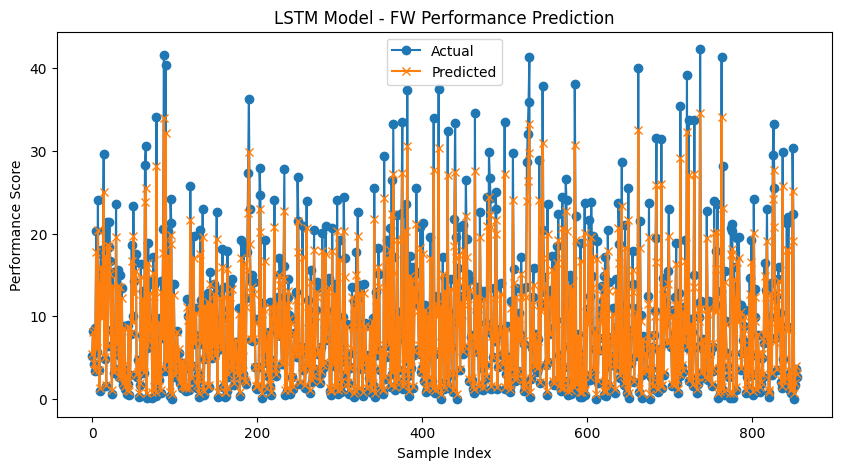


🔍 Training LSTM for MF...

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


296/296 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - loss: 152.1482 - val_loss: 25.8384
Epoch 2/50
296/296 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 30.0066 - val_loss: 42.5813
Epoch 3/50
296/296 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 24.5067 - val_loss: 37.5565
Epoch 4/50
296/296 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 23.3912 - val_loss: 33.6617
Epoch 5/50
296/296 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 19.6990 - val_loss: 27.7466
Epoch 6/50
296/296 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 17.5628 - val_loss: 35.3748
Epoch 7/50
296/296 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 20.2080 - val_loss: 29.8379
Epoch 8/50
296/296 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 17.9381 - val_loss: 35.7062
Epoch 9/50
296/296 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 19.7679 - val_loss: 14.1885
Epoch 10/50
296/296 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 15.6545 - val_loss: 26.3869
Epoch 11/50
296/296 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 15.4235 - val_loss: 31.8082
Epoch 12/50
296/296 ━━━━━━━━━━━━━━━━━━━━

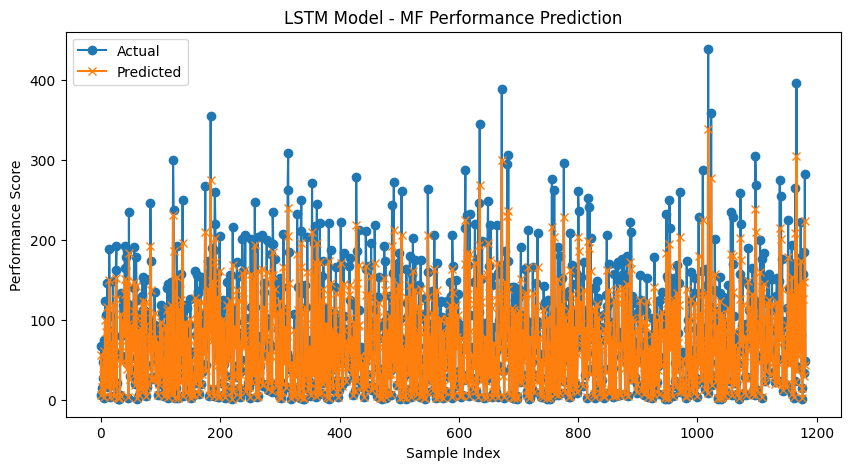


🔍 Training LSTM for DF...

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


335/335 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - loss: 5.1743 - val_loss: 1.1226
Epoch 2/50
335/335 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 1.0582 - val_loss: 0.9953
Epoch 3/50
335/335 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.9412 - val_loss: 0.9212
Epoch 4/50
335/335 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.7747 - val_loss: 0.8260
Epoch 5/50
335/335 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.7068 - val_loss: 0.9667
Epoch 6/50
335/335 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.5536 - val_loss: 0.9584
Epoch 7/50
335/335 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.6315 - val_loss: 1.3310
Epoch 8/50
335/335 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.5608 - val_loss: 0.8531
Epoch 9/50
335/335 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.4621 - val_loss: 0.5725
Epoch 10/50
335/335 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.4591 - val_loss: 0.7214
Epoch 11/50
335/335 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.4083 - val_loss: 0.8006
Epoch 12/50
335/335 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.

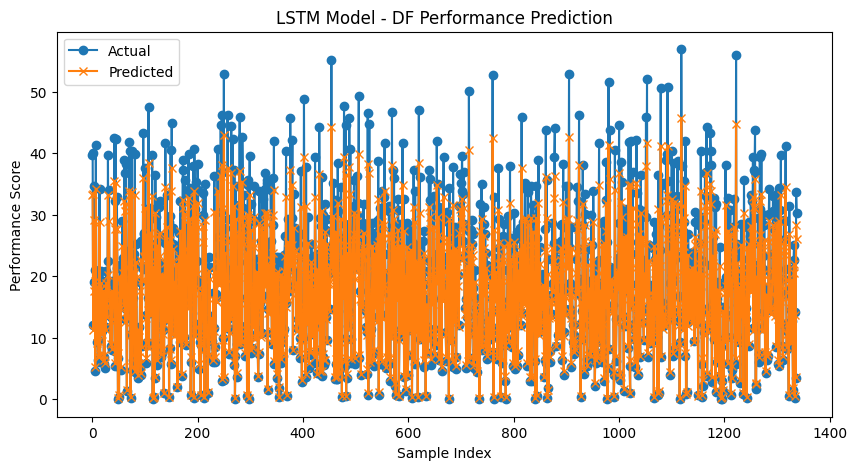


🔍 Training LSTM for GK...

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


69/69 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 23.1590 - val_loss: 1.0959
Epoch 2/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.4229 - val_loss: 0.8077
Epoch 3/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.2932 - val_loss: 0.9605
Epoch 4/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.7738 - val_loss: 0.7336
Epoch 5/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.8215 - val_loss: 1.9169
Epoch 6/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 1.4603 - val_loss: 0.8874
Epoch 7/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 1.4825 - val_loss: 1.4621
Epoch 8/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.2473 - val_loss: 0.9735
Epoch 9/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.3779 - val_loss: 1.2991
Epoch 10/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.1402 - val_loss: 1.6457
Epoch 11/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.0490 - val_loss: 0.8906
Epoch 12/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.1114 - val_loss: 0.5

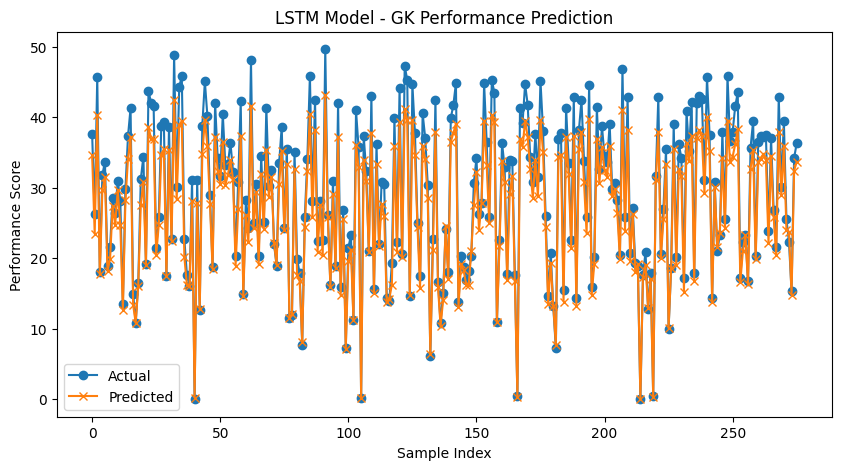

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

# Load dataset
df = pd.read_csv("cleaned_all_seasons.csv")

# Define UEFA coefficient-based league strength index
uefa_coefficients = {
    "Premier League": 1.00, "La Liga": 0.95, "Bundesliga": 0.90, "Serie A": 0.88, "Ligue 1": 0.85,
    "Primeira Liga": 0.80, "Eredivisie": 0.75, "Russian Premier League": 0.70, "Belgian Pro League": 0.68,
    "Scottish Premiership": 0.65, "Turkish Süper Lig": 0.63, "Ukrainian Premier League": 0.60,
    "Austrian Bundesliga": 0.58, "Swiss Super League": 0.55, "Greek Super League": 0.50, "Other": 0.40
}

# Map the league name to the index
df["league_index"] = df["comp"].map(lambda x: uefa_coefficients.get(x, 0.40))  # Default to 0.40 for unknown leagues

# Define position-wise feature importance (weights computed earlier)
feature_weights = {
    "FW": {
        "Goals": 0.20, "Expected Goals": 0.15, "Non Penalty Goals": 0.10,
        "Progressive Carries": 0.10, "Take ons attempted": 0.05, "Passes into penalty area": 0.05,
        "Assists": 0.10, "Shots p 90": 0.10, "Goals p 90": 0.10, "Progressive Passes": 0.05
    },
    "MF": {
        "carries final 3rd": 0.10, "carries_prgc": 0.10, "Progressive Carries": 0.10,
        "Passes into penalty area": 0.10, "Possessions lost": 0.05, "Progressive Passes": 0.10,
        "Passes blocked": 0.05, "Assists": 0.10, "Exp NPG": 0.10, "Expected Goals": 0.05,
        "carries penalty area": 0.05, "Passes Attempted": 0.10
    },
    "DF": {
        "Tackles attempted": 0.15, "Tackles Won": 0.15, "Interceptions": 0.15,
        "Passes blocked": 0.10, "Clearances": 0.10, "Shots blocked": 0.10,
        "Key passes": 0.05, "Possessions lost": 0.05, "Goals against p 90": 0.05,
        "% Dribbles tackled": 0.05, "Errors made": 0.05
    },
    "GK": {
        "Saves %": 0.20, "Saves": 0.15, "Goals Against": 0.10,
        "Clean Sheets": 0.10, "Crosses Stopped": 0.10, "Goals against p 90": 0.10,
        "% Clean sheets": 0.10, "% Penalty saves": 0.10, "Errors made": 0.05
    }
}

# Function to compute performance score using feature weights
def compute_performance(row, pos):
    if pos not in feature_weights:
        return np.nan  # Skip unknown positions

    score = sum(row[feature] * weight for feature, weight in feature_weights[pos].items() if feature in row)
    return score

# Compute performance score for each player
df["Performance Score"] = df.apply(lambda row: compute_performance(row, row["pos"]), axis=1)

# Scale performance scores
scaler = MinMaxScaler(feature_range=(0, 100))
df["Performance Score"] = scaler.fit_transform(df[["Performance Score"]])

# Select important features + performance score for each position
position_dfs = {}
for position in feature_weights.keys():
    pos_df = df[df["pos"] == position].copy()
    pos_features = list(feature_weights[position].keys()) + ["age", "league_index", "Performance Score"]

    # Drop missing values
    pos_df = pos_df[pos_features].dropna()

    # Store cleaned position dataset
    position_dfs[position] = pos_df

# Train separate LSTM models for each position
models = {}
histories = {}

for position, pos_df in position_dfs.items():
    print(f"\n🔍 Training LSTM for {position}...\n")

    # Prepare data for LSTM
    X = pos_df.drop(columns=["Performance Score"]).values
    y = pos_df["Performance Score"].values

    # Reshape for LSTM: (samples, timesteps, features)
    X = X.reshape(X.shape[0], 1, X.shape[1])

    # Split into train & test (80-20 split)
    train_size = int(0.8 * len(X))
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]

    # Define LSTM model
    model = Sequential([
        LSTM(50, activation='relu', return_sequences=True, input_shape=(1, X.shape[2])),
        Dropout(0.2),
        LSTM(50, activation='relu'),
        Dropout(0.2),
        Dense(1)
    ])

    model.compile(optimizer='adam', loss='mse')

    # Train model
    history = model.fit(X_train, y_train, epochs=50, batch_size=16, validation_data=(X_test, y_test), verbose=1)

    # Store trained model and history
    models[position] = model
    histories[position] = history

    # Evaluate Model
    y_pred = model.predict(X_test)

    # Convert back to original scale
    y_test_original = scaler.inverse_transform(y_test.reshape(-1, 1))
    y_pred_original = scaler.inverse_transform(y_pred)

    # Compare actual vs predicted performance
    results_df = pd.DataFrame({
        "Actual Performance": y_test_original.flatten(),
        "Predicted Performance": y_pred_original.flatten()
    })

    # Display actual vs predicted performance
    print(f"\n📊 Performance Comparison for {position}:\n")
    print(results_df.head(10))

    # Plot results
    plt.figure(figsize=(10, 5))
    plt.plot(y_test_original, label="Actual", marker='o')
    plt.plot(y_pred_original, label="Predicted", marker='x')
    plt.title(f"LSTM Model - {position} Performance Prediction")
    plt.xlabel("Sample Index")
    plt.ylabel("Performance Score")
    plt.legend()
    plt.show()


In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, MultiHeadAttention, LayerNormalization, Dropout
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Load dataset
df = pd.read_csv("cleaned_all_seasons.csv")

#  One-Hot Encode "pos"
pos_encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
pos_encoded = pos_encoder.fit_transform(df[["pos"]])

# Convert encoded positions to DataFrame
pos_encoded_df = pd.DataFrame(pos_encoded, columns=pos_encoder.categories_[0])

# Identify non-numeric columns
non_numeric_cols = df.select_dtypes(exclude=[np.number]).columns
df = df.drop(columns=["player", "nation", "squad", "comp", "pos"]).reset_index(drop=True)

# Merge one-hot encoded "pos" back into the dataframe
df = pd.concat([df, pos_encoded_df], axis=1)

#  Ensure only numeric data before normalization
numeric_cols = df.select_dtypes(include=[np.number]).columns
df = df[numeric_cols]  # Keep only numeric columns

# Normalize numeric data
scaler = MinMaxScaler()
df[df.columns] = scaler.fit_transform(df[df.columns])  # Scale all numeric columns

print(" Data cleaned and 'pos' encoded successfully!")

# Define function to compute Performance Score
feature_weights = {
    "FW": {"Goals": 0.20, "Expected Goals": 0.15, "Non Penalty Goals": 0.10,
           "Progressive Carries": 0.10, "Take ons attempted": 0.05, "Passes into penalty area": 0.05,
           "Assists": 0.10, "Shots p 90": 0.10, "Goals p 90": 0.10, "Progressive Passes": 0.05},

    "MF": {"carries final 3rd": 0.10, "carries_prgc": 0.10, "Progressive Carries": 0.10,
           "Passes into penalty area": 0.10, "Possessions lost": 0.05, "Progressive Passes": 0.10,
           "Passes blocked": 0.05, "Assists": 0.10, "Exp NPG": 0.10, "Expected Goals": 0.05,
           "carries penalty area": 0.05, "Passes Attempted": 0.10},

    "DF": {"Tackles attempted": 0.15, "Tackles Won": 0.15, "Interceptions": 0.15,
           "Passes blocked": 0.10, "Clearances": 0.10, "Shots blocked": 0.10,
           "Key passes": 0.05, "Possessions lost": 0.05, "Goals against p 90": 0.05,
           "% Dribbles tackled": 0.05, "Errors made": 0.05},

    "GK": {"Saves %": 0.20, "Saves": 0.15, "Goals Against": 0.10,
           "Clean Sheets": 0.10, "Crosses Stopped": 0.10, "Goals against p 90": 0.10,
           "% Clean sheets": 0.10, "% Penalty saves": 0.10, "Errors made": 0.05}
}

# FIX: Compute Performance Score correctly using one-hot encoded positions
def compute_performance(row):
    position = row[list(feature_weights.keys())].idxmax()  # Get the player's position
    if position in feature_weights:
        return sum(row.get(feature, 0) * weight for feature, weight in feature_weights[position].items())
    return np.nan  # If position not found

df["Performance Score"] = df.apply(compute_performance, axis=1)

# Normalize Performance Score
df["Performance Score"] = scaler.fit_transform(df[["Performance Score"]])

print(" Performance Score calculated and normalized!")

# Function to create sequences
def create_sequences(data, sequence_length):
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[i:i + sequence_length, :-1])  # Past sequence_length seasons
        y.append(data[i + sequence_length, -1])  # Next season's performance
    return np.array(X), np.array(y)

sequence_length = 5  # Use past 5 seasons as input

# Define Transformer Encoder Layer
def transformer_encoder(inputs, num_heads=8, key_dim=64, dropout=0.1):
    attention_output = MultiHeadAttention(num_heads=num_heads, key_dim=key_dim)(inputs, inputs)
    attention_output = Dropout(dropout)(attention_output)
    attention_output = LayerNormalization(epsilon=1e-6)(inputs + attention_output)

    # Feedforward layer
    ffn = Dense(64, activation="relu")(attention_output)
    ffn = Dense(inputs.shape[-1])(ffn)
    ffn = Dropout(dropout)(ffn)

    output = LayerNormalization(epsilon=1e-6)(attention_output + ffn)
    return output

# Define Transformer Model
def build_transformer_model(sequence_length, feature_dim):
    inputs = Input(shape=(sequence_length, feature_dim))

    x = transformer_encoder(inputs)
    x = transformer_encoder(x)
    x = Dense(32, activation="relu")(x)
    x = Dense(16, activation="relu")(x)
    outputs = Dense(1)(x)  # Predict Performance Score

    model = Model(inputs, outputs)
    model.compile(optimizer="adam", loss="mse")
    return model

models = {}

for position in pos_encoder.categories_[0]:  # Loop through FW, MF, DF, GK
    print(f"\n🔍 Training Transformer for {position}...\n")

    pos_df = df[df[position] == 1].dropna().values  # Select data for specific position

    # Create sequences
    X, y = create_sequences(pos_df, sequence_length)

    # Split into train & test
    train_size = int(0.8 * len(X))
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]

    # Define Transformer Model
    model = build_transformer_model(sequence_length, X.shape[2])

    # Train Model
    model.fit(X_train, y_train, epochs=50, batch_size=16, validation_data=(X_test, y_test), verbose=1)

    # Store Model
    models[position] = model

    # Predict on test set
    y_pred = model.predict(X_test)

    # ✅ FIX: Ensure y_pred and y_test have the same shape
    y_pred = y_pred.flatten()[:len(y_test)]  # Trim excess predictions if necessary

    # Convert back to original scale
    y_test_original = y_test * 100
    y_pred_original = y_pred * 100

    # Compute Evaluation Metrics
    mse = mean_squared_error(y_test_original, y_pred_original)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test_original, y_pred_original)
    r2 = r2_score(y_test_original, y_pred_original)

    print(f"\n📊 Evaluation Metrics for {position}:")
    print(f"🔹 Mean Squared Error (MSE): {mse:.4f}")
    print(f"🔹 Root Mean Squared Error (RMSE): {rmse:.4f}")
    print(f"🔹 Mean Absolute Error (MAE): {mae:.4f}")
    print(f"🔹 R² Score: {r2:.4f}")
